# Neural network implementation of a classification model aimed at breast cancer diagnosis

In [1]:
%pip uninstall -y jax tensorstore thinc #for colab compatibility
%pip install "tensorflow==2.16.1" "keras==3.2.0" "scikeras==0.13.0" "scikit-learn==1.4.2" numpy pandas imblearn matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas
import numpy as np

from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

import keras
from keras.models import Sequential                 
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.losses import BinaryCrossentropy
from keras.optimizers import SGD, Adam    

from scikeras.wrappers import KerasClassifier

from scipy.stats import truncnorm

import matplotlib.pyplot as plt

2025-06-09 14:15:51.334990: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 14:15:51.335276: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 14:15:51.355484: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-09 14:15:51.534158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-09 14:15:52.463451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [3]:
data = load_breast_cancer(as_frame=True)
X: pandas.DataFrame=data.data
y: pandas.Series=data.target

## Data Analysis

In [4]:
y.value_counts()

target
1    357
0    212
Name: count, dtype: int64

Classes are imbalanced, i will use SMOTE to extend the 0 class.

In [5]:
X.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We can see how each of the 30 features are actually 3 properties of the same metric (the mean, the error, and the worst example).

In [6]:
# Check for missing data
X.isnull().sum(axis=0)

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

No missing values

## Preprocessing

### Conversion to numpy

In [7]:
X: np.ndarray=X.to_numpy()
y: np.ndarray=y.to_numpy()

### Train test split

In [8]:
Xtr, Xte, ytr, yte = train_test_split(X,y, test_size=0.2)


### Upsampling through SMOTE

In [9]:
smote = SMOTE()
Xtr,ytr = smote.fit_resample(Xtr, ytr)
print(f'class 0 elements: {np.sum(ytr==0)}, class 1 elements: {np.sum(ytr==1)}')

class 0 elements: 285, class 1 elements: 285


### Standard Scaling
being already in a normally distributed, the data can be scaled with a standard scaler to make convergence faster and the model more accurate

In [10]:

stSc=StandardScaler()
Xtr=stSc.fit_transform(Xtr)
Xte=stSc.transform(Xte)

## NN Construction

In [11]:
def getModel(l1N: int, l2N: int, activation: str, l1DropOut: float, l2DropOut: float, l1Normalization: bool, l2Normalization: bool, optimizer:keras.optimizers)->Sequential:    
    # define model
    model: Sequential= Sequential()
    model.add(Input((30,), name='Input'))
    
    model.add(Dense(units=l1N, activation=activation, name=f'L1Dense'))
    if l1DropOut>0:
        model.add(Dropout(rate=l1DropOut, name=f'L1Dropout'))
    if l1Normalization:
        model.add(BatchNormalization(name=f'L1Norm'))
    
    model.add(Dense(units=l2N, activation=activation, name=f'L2Dense'))
    if l2DropOut>0:
        model.add(Dropout(rate=l2DropOut, name=f'L2Dropout'))
    if l2Normalization:
        model.add(BatchNormalization(name=f'L2Norm'))
    
    model.add(Dense(1, 'sigmoid', name=f'L3Dense-Output'))

        
    model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
    return model

### Test

In [12]:
model=getModel(64, 128, 'relu', 0.3, 0.3, True, True, SGD())

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1Dense (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1Dropout (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1Norm (BatchNormalization)     │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2Dense (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2Dropout (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2Norm (BatchNormalization)     │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3Dense-Output (Dense)          │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,201 (43.75 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [13]:
model.fit(Xtr,ytr, batch_size=10, epochs=5)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7118 - loss: 0.6047 
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.9034 - loss: 0.2708
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8953 - loss: 0.2583
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.9101 - loss: 0.2173
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.9189 - loss: 0.2128


## Model selection

to select the best hyperparameters, a randomized grid search will be used.

In [14]:
classifier = KerasClassifier(model=getModel)

In [15]:
dropoutDist=truncnorm(0, 0.6, 0.2, 0.15)

param_distributions={
    'model__l1N': [5,10,20,40,80,160],
    'model__l2N': [5,10,20,40,80,160],
    'model__activation': ['sigmoid', 'relu'],
    'model__l1DropOut': dropoutDist,
    'model__l2DropOut': dropoutDist,
    'model__l1Normalization': [False, True],
    'model__l2Normalization': [False, True],
    'model__optimizer': [SGD(0.001), SGD(0.01), SGD(0.1), SGD(0.15), Adam(0.001), Adam(0.01), Adam(0.1), Adam(0.15)],
    'optimizer': [SGD(0.001), SGD(0.01), SGD(0.1), SGD(0.15), Adam(0.001), Adam(0.01), Adam(0.1), Adam(0.15)],
    'batch_size': [10,15,20,25,30]
}

In [16]:
rscv=RandomizedSearchCV(classifier, param_distributions=param_distributions, cv=10)
rscv.fit(Xtr, ytr) #usually takes less than 2 minutes

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5185 - loss: 0.7966  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.5203 - loss: 0.7184
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.5776 - loss: 0.6928
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f03806772e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.te

RandomizedSearchCV(cv=10,
                   estimator=KerasClassifier(model=<function getModel at 0x7f039028df30>),
                   param_distributions={'batch_size': [10, 15, 20, 25, 30],
                                        'model__activation': ['sigmoid',
                                                              'relu'],
                                        'model__l1DropOut': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f039029bee0>,
                                        'model__l1N': [5, 10, 20, 40, 80, 160],
                                        'model__l1Normalization': [False, True...
                                                      <keras.src.optimizers.sgd.SGD object at 0x7f038855e8c0>,
                                                      <keras.src.optimizers.sgd.SGD object at 0x7f038855ee30>,
                                                      <keras.src.optimizers.sgd.SGD object at 0x7f038855f3a0>,
                                                      <keras.src.optimizers.adam.Adam object at 0x7f038855f910>,
                                                      <keras.src.optimizers.adam.Adam object at 0x7f038855fe80>,
                                                      <keras.src.optimizers.adam.Adam object at 0x7f0388594430>,
                                                      <keras.src.optimizers.adam.Adam object at 0x7f03885949a0>]})

In [17]:
rscv.best_params_

{'batch_size': 25,
 'model__activation': 'sigmoid',
 'model__l1DropOut': 0.20941564683951677,
 'model__l1N': 20,
 'model__l1Normalization': True,
 'model__l2DropOut': 0.23800661614181398,
 'model__l2N': 80,
 'model__l2Normalization': False,
 'model__optimizer': <keras.src.optimizers.adam.Adam at 0x7f038855da50>,
 'optimizer': <keras.src.optimizers.adam.Adam at 0x7f038855fe80>}

In [18]:
rscv.best_score_

0.9561403508771928

## Test

In [19]:
# create a new model with the best params
modelParams={}
fitParams={}

for k in rscv.best_params_.keys():
    if 'optimizer' in k:
        optimizer: keras.optimizers=None
        if type(rscv.best_params_[k])==SGD:
            optimizer=SGD(**rscv.best_params_[k].get_config())
        elif type(rscv.best_params_[k])==Adam:
            optimizer=Adam(**rscv.best_params_[k].get_config())
        else:
            raise Exception("Unrecognized optimizer")
        
        
        if 'model__' in k:
            modelParams[k.removeprefix('model__')]=optimizer
                
    elif 'model__' in k:
        modelParams[k.removeprefix('model__')]=rscv.best_params_[k]
    else:
        fitParams[k]=rscv.best_params_[k]


print('model params:',modelParams)
print('fit params:',fitParams)

model=getModel(**modelParams)
model.summary()


model params: {'activation': 'sigmoid', 'l1DropOut': 0.20941564683951677, 'l1N': 20, 'l1Normalization': True, 'l2DropOut': 0.23800661614181398, 'l2N': 80, 'l2Normalization': False, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x7f043c28e800>}
fit params: {'batch_size': 25}


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1Dense (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1Dropout (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1Norm (BatchNormalization)     │ (None, 20)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2Dense (Dense)                 │ (None, 80)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2Dropout (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3Dense-Output (Dense)          │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,461 (9.61 KB)

 Trainable params: 2,421 (9.46 KB)

 Non-trainable params: 40 (160.00 B)

In [20]:
history=model.fit(np.copy(Xtr), np.copy(ytr), **fitParams, epochs=50, validation_split=0.2)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7563 - loss: 0.4570 - val_accuracy: 0.9474 - val_loss: 0.2129
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9302 - loss: 0.1930 - val_accuracy: 0.9474 - val_loss: 0.2157
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9708 - loss: 0.1263 - val_accuracy: 0.9825 - val_loss: 0.0839
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 0.0811 - val_accuracy: 0.9825 - val_loss: 0.0804
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0684 - val_accuracy: 0.9825 - val_loss: 0.0661
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0711 - val_accuracy: 0.9737 - val_loss: 0.0887
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0611 - val_accuracy: 0.9825 - val_loss: 0.0611
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9791 - loss: 0.0744 - val_accuracy: 0.9825 - val_loss:

### Results

In [21]:
predicted=model.predict(Xte)
predicted=predicted>=0.5
print(f"Final test accuracy: {accuracy_score(yte,predicted)}")
print(f"Final test f1 score: {f1_score(yte,predicted)}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Final test accuracy: 0.9649122807017544
Final test f1 score: 0.9726027397260274


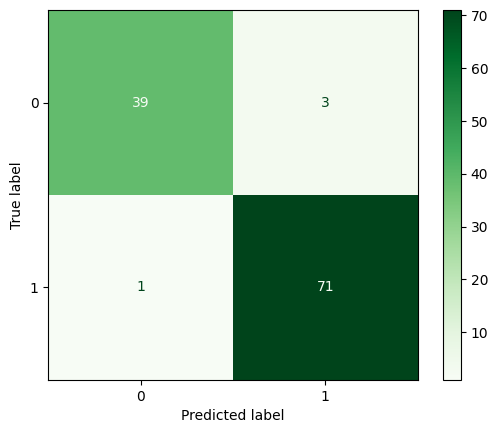

In [22]:
cm = confusion_matrix(yte, predicted)
ConfusionMatrixDisplay(cm).plot(cmap="Greens")

#### Learning curve

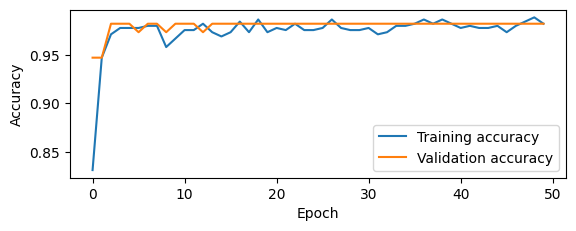

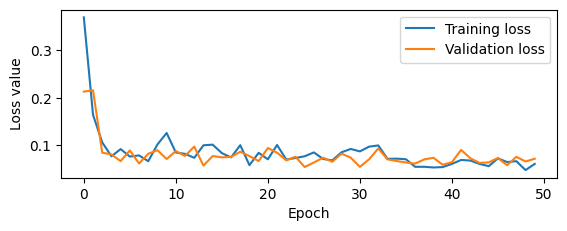

In [23]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()